# A short notebook for Cross-Correlation and PCA on Glacier Data
## Lucy and Michael

In [2]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
import seaborn as sns

In [34]:
# Load the glacier data as a pandas dataframe
data_file = 'RGI2000-v7.0-G-01_alaska-attributes.csv'

glacier_df = pd.read_csv(data_file)

In [35]:
# Display the first few rows of the dataframe
display(glacier_df.head())

,rgi_id,o1region,o2region,glims_id,anlys_id,subm_id,src_date,cenlon,cenlat,utm_zone,...,termlat,zmin_m,zmax_m,zmed_m,zmean_m,slope_deg,aspect_deg,aspect_sec,dem_source,lmax_m
0,RGI2000-v7.0-G-01-00001,1,01-01,G204091E67414N,392889,624,2008-09-02T00:00:00,-155.909404,67.413726,5,...,67.416034,1485.3176,1693.6235,1544.6694,1553.9403,17.606613,342.330469,1,COPDEM30,725
1,RGI2000-v7.0-G-01-00002,1,01-01,G204121E67419N,392890,624,2008-09-02T00:00:00,-155.879114,67.419232,5,...,67.421273,1278.4006,1394.7657,1328.5566,1330.9150,19.846369,345.367012,1,COPDEM30,484
2,RGI2000-v7.0-G-01-00003,1,01-01,G204471E67431N,392897,624,2008-09-02T00:00:00,-155.530786,67.431484,5,...,67.435694,1294.7034,1704.7420,1423.2068,1437.2352,23.690063,13.467490,1,COPDEM30,1099
3,RGI2000-v7.0-G-01-00004,1,01-01,G204497E67431N,392899,624,2008-09-02T00:00:00,-155.501948,67.430514,5,...,67.433367,1224.1788,1286.8977,1249.6306,1249.0662,12.782562,42.854332,2,COPDEM30,652
4,RGI2000-v7.0-G-01-00005,1,01-01,G204521E67429N,392901,624,2008-09-02T00:00:00,-155.478173,67.432873,5,...,67.438901,1052.4401,1488.1299,1290.8923,1273.7834,17.148510,299.058193,8,COPDEM30,1903


In [36]:
# Drop data id columns and columns that have the same value for all datapoints - not helpful for PCA
glacier_df = glacier_df.drop(columns=['rgi_id', 'o1region', 'o2region', 'subm_id', 'utm_zone', 'dem_source', 
                                      'primeclass', 'conn_lvl', 'surge_type', 'term_type', 'is_rgi6', 'glac_name', 'aspect_sec', 'anlys_id'])

In [37]:
# Display the cleaned dataframe
display(glacier_df.head(100))


,glims_id,src_date,cenlon,cenlat,area_km2,termlon,termlat,zmin_m,zmax_m,zmed_m,zmean_m,slope_deg,aspect_deg,lmax_m
0,G204091E67414N,2008-09-02T00:00:00,-155.909404,67.413726,0.239199,-155.904032,67.416034,1485.3176,1693.6235,1544.6694,1553.9403,17.606613,342.330469,725
1,G204121E67419N,2008-09-02T00:00:00,-155.879114,67.419232,0.104641,-155.878512,67.421273,1278.4006,1394.7657,1328.5566,1330.9150,19.846369,345.367012,484
2,G204471E67431N,2008-09-02T00:00:00,-155.530786,67.431484,0.216605,-155.529516,67.435694,1294.7034,1704.7420,1423.2068,1437.2352,23.690063,13.467490,1099
3,G204497E67431N,2008-09-02T00:00:00,-155.501948,67.430514,0.252649,-155.502283,67.433367,1224.1788,1286.8977,1249.6306,1249.0662,12.782562,42.854332,652
4,G204521E67429N,2008-09-02T00:00:00,-155.478173,67.432873,0.474716,-155.499392,67.438901,1052.4401,1488.1299,1290.8923,1273.7834,17.148510,299.058193,1903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,G209864E68281N,2007-07-02T00:00:00,-150.136455,68.281284,0.145205,-150.137897,68.283760,1847.5875,2096.4897,1990.3903,1980.1068,23.211796,11.944481,677
96,G209876E68282N,2007-07-02T00:00:00,-150.123144,68.282224,0.257954,-150.128127,68.284635,1818.7584,2089.0786,1914.4536,1925.2638,23.375004,331.990046,875
97,G210174E68333N,2007-08-09T00:00:00,-149.824637,68.333597,0.319043,-149.829514,68.337989,1815.3230,2223.2030,1964.7534,1973.0153,21.421215,14.042233,1056
98,G210196E68329N,2007-08-09T00:00:00,-149.805472,68.329568,0.516742,-149.806411,68.332977,1860.5848,2202.5251,2000.0120,2007.4934,24.728983,12.259882,897


In [38]:
# Drop columns with missing values and strings
glacier_df = glacier_df.dropna(axis=1)
glacier_df = glacier_df.select_dtypes(include=[np.number])

In [39]:
# Look at correlations between variables
# Now, let's calculate a *correlation matrix*
correlation_matrix = glacier_df.corr()

# Finally, let us display the correlation matrix with a color gradient
correlation_matrix.style.background_gradient(cmap='coolwarm')

,cenlon,cenlat,area_km2,termlon,termlat,zmin_m,zmax_m,zmed_m,zmean_m,slope_deg,aspect_deg,lmax_m
cenlon,1.000000,-0.539581,-0.000631,0.999994,-0.539482,0.121238,0.113462,0.141744,0.138500,0.021095,-0.092966,-0.007697
cenlat,-0.539581,1.000000,0.008230,-0.539562,0.999990,0.290131,0.259682,0.281871,0.285072,0.062618,0.024593,0.010378
area_km2,-0.000631,0.008230,1.000000,-0.000824,0.006831,-0.121162,0.187795,-0.001716,-0.003735,-0.119344,-0.004918,0.797626
termlon,0.999994,-0.539562,-0.000824,1.000000,-0.539462,0.121268,0.113424,0.141754,0.138510,0.021091,-0.093871,-0.007800
termlat,-0.539482,0.999990,0.006831,-0.539462,1.000000,0.290178,0.259647,0.281944,0.285149,0.062538,0.024559,0.009599
zmin_m,0.121238,0.290131,-0.121162,0.121268,0.290178,1.000000,0.721296,0.919327,0.925453,0.323383,-0.053821,-0.256154
zmax_m,0.113462,0.259682,0.187795,0.113424,0.259647,0.721296,1.000000,0.911780,0.915380,0.174473,-0.056707,0.305846
zmed_m,0.141744,0.281871,-0.001716,0.141754,0.281944,0.919327,0.911780,1.000000,0.998726,0.272154,-0.059912,-0.005562
zmean_m,0.138500,0.285072,-0.003735,0.138510,0.285149,0.925453,0.915380,0.998726,1.000000,0.274637,-0.060017,-0.008803
slope_deg,0.021095,0.062618,-0.119344,0.021091,0.062538,0.323383,0.174473,0.272154,0.274637,1.000000,-0.004214,-0.292909


In [40]:
# Let's drop variables with high correlation: we will drop lmax_m, zmin_m, zmax_m, and zmed_m
glacier_df = glacier_df.drop(columns=['lmax_m', 'zmin_m', 'zmax_m', 'zmed_m'])

# Replot the correlation matrix to confirm nothing is highly correlated
correlation_matrix = glacier_df.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm')

,cenlon,cenlat,area_km2,termlon,termlat,zmean_m,slope_deg,aspect_deg
cenlon,1.000000,-0.539581,-0.000631,0.999994,-0.539482,0.138500,0.021095,-0.092966
cenlat,-0.539581,1.000000,0.008230,-0.539562,0.999990,0.285072,0.062618,0.024593
area_km2,-0.000631,0.008230,1.000000,-0.000824,0.006831,-0.003735,-0.119344,-0.004918
termlon,0.999994,-0.539562,-0.000824,1.000000,-0.539462,0.138510,0.021091,-0.093871
termlat,-0.539482,0.999990,0.006831,-0.539462,1.000000,0.285149,0.062538,0.024559
zmean_m,0.138500,0.285072,-0.003735,0.138510,0.285149,1.000000,0.274637,-0.060017
slope_deg,0.021095,0.062618,-0.119344,0.021091,0.062538,0.274637,1.000000,-0.004214
aspect_deg,-0.092966,0.024593,-0.004918,-0.093871,0.024559,-0.060017,-0.004214,1.000000


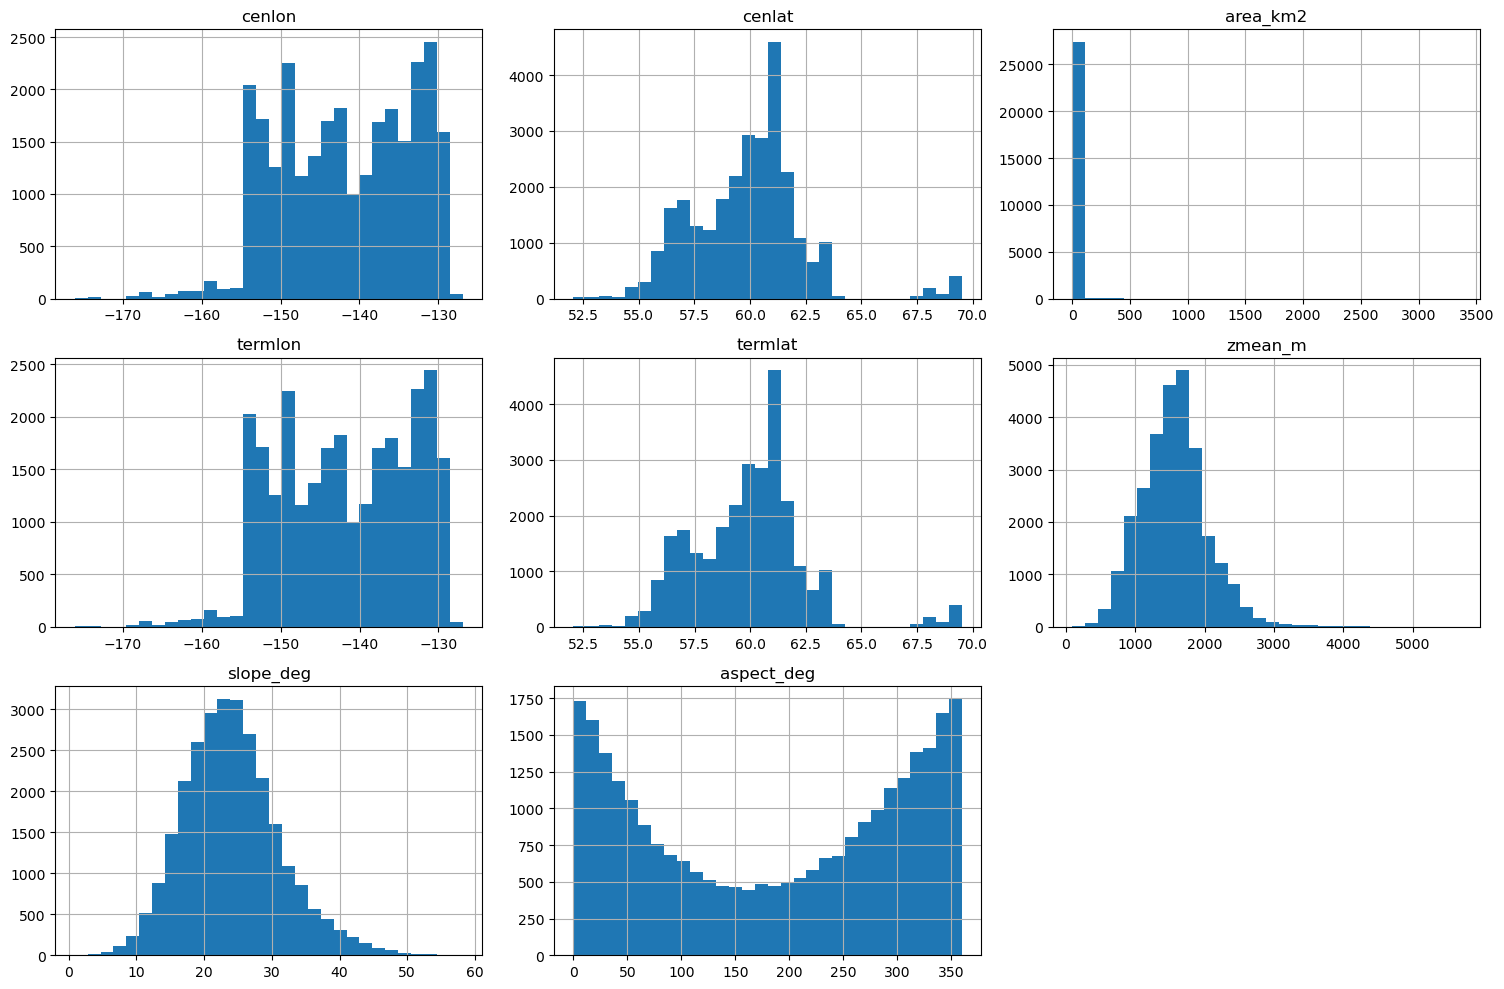

In [41]:
# We will keep both the centroid and terminus coordinates for now, even though they have high correlation
# Plot histograms of all variables
glacier_df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [42]:
# Perform PCA on the cleaned dataframe

# Let's center the data by subtracting the mean
# Note that we do not *normalize* the data
glacier_df_centered = glacier_df - glacier_df.mean()

In [43]:
# Apply SVD to perform PCA
U, S, Vt = np.linalg.svd(glacier_df_centered, full_matrices=False)

# Project data onto principal components (scores)
pca_result = U * S

# Calculate explained variance ratio
explained_variance = (S ** 2) / (len(glacier_df_centered) - 1)
explained_variance_ratio = explained_variance / explained_variance.sum()

# What proportion is variance is explained by each PC?
print("Explained variance:")
for i, var in enumerate(explained_variance_ratio):
    print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%)")

Explained variance:
  PC1: 0.9343 (93.43%)
  PC2: 0.0582 (5.82%)
  PC3: 0.0067 (0.67%)
  PC4: 0.0005 (0.05%)
  PC5: 0.0002 (0.02%)
  PC6: 0.0000 (0.00%)
  PC7: 0.0000 (0.00%)
  PC8: 0.0000 (0.00%)


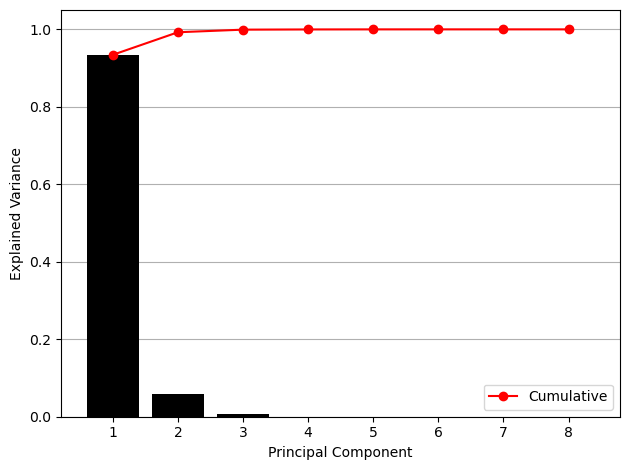

In [44]:
# We can also create a *scree* plot of pcs

fig, ax = plt.subplots()
ax.bar(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, 
       color='black')
ax.plot(range(1, len(explained_variance_ratio)+1), np.cumsum(explained_variance_ratio), 
        'ro-', label='Cumulative')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
ax.set_xticks(range(1, len(explained_variance_ratio)+1))
ax.legend()
ax.grid(True, axis='y')
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

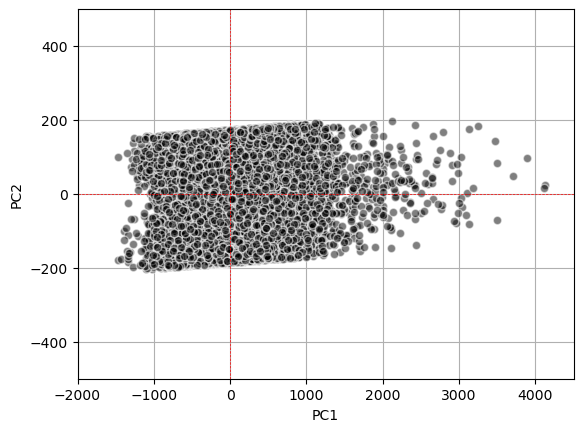

In [51]:
# Plot the principal components
fig, ax = plt.subplots()
ax.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, color='k', edgecolors='w')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.axhline(y=0, color='r', linestyle='--', linewidth=0.5)
ax.axvline(x=0, color='r', linestyle='--', linewidth=0.5)
ax.set_xlim(-2000, 4500)
ax.set_ylim(-500, 500)
#ax.set_aspect('equal')
ax.grid(True)
ax.set_axisbelow(True)
plt.show()

In [46]:
# What makes up each PC?

# Define our glacier columns - pull from dataframe
glacier_cols = glacier_df.columns.tolist()

# Loadings (principal component vectors) are the rows of Vt
loadings = pd.DataFrame(Vt.T, index=glacier_cols, columns=[f'PC{i+1}' for i in range(len(glacier_cols))])
print("\nLoadings for PC1 and PC2:")
print(loadings[['PC1', 'PC2']])


Loadings for PC1 and PC2:
                 PC1       PC2
cenlon      0.002365 -0.005799
cenlat      0.001451  0.000885
area_km2   -0.000316 -0.001974
termlon     0.002365 -0.005861
termlat     0.001451  0.000885
zmean_m     0.999856  0.016034
slope_deg   0.003985  0.000786
aspect_deg -0.016013  0.999834


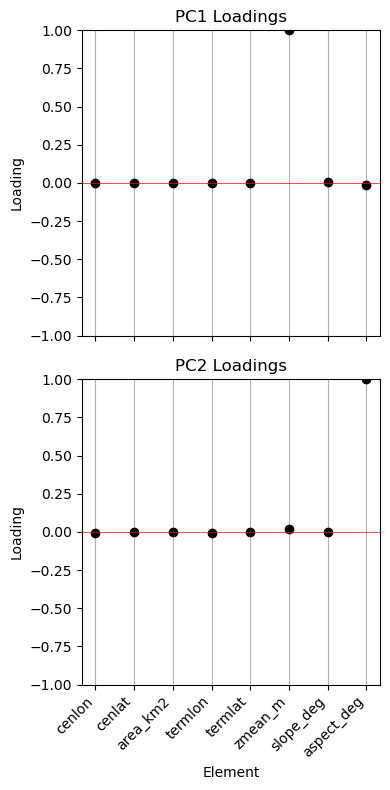

In [47]:
# Why don't we visualize these loadings?
fig, axes = plt.subplots(2, 1, figsize=(4, 8), sharex=True)
x = np.arange(len(glacier_cols))

# PC1 loadings
ax1 = axes[0]
ax1.scatter(x, loadings['PC1'], color='black')
ax1.set_ylabel('Loading')
ax1.axhline(y=0, color='r', linestyle='-', linewidth=0.5)
ax1.set_ylim(-1, 1)
ax1.grid(True, axis='x')
ax1.set_axisbelow(True)
ax1.set_title('PC1 Loadings')

# PC2 loadings
ax2 = axes[1]
ax2.scatter(x, loadings['PC2'], color='black')
ax2.set_ylabel('Loading')
ax2.set_xlabel('Element')
ax2.set_xticks(x)
ax2.set_xticklabels(glacier_cols, rotation=45, ha='right')
ax2.axhline(y=0, color='r', linestyle='-', linewidth=0.5)
ax2.set_ylim(-1, 1)
ax2.grid(True, axis='x')
ax2.set_axisbelow(True)
ax2.set_title('PC2 Loadings')

plt.tight_layout()
plt.show()